In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.5f' % x)

plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False
MAX_YEAR = 5


colors = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
    '#999999', '#e41a1c', '#dede00'
] * 2
contrast_colors = [
    colors[0], colors[0], colors[1], colors[1]
] * 2
maturities = [0, 31, 92, 182, 273, 365, 365*2, 365*3, 365*4, 365*5, 365*10]
labels = ['0-1mo', '1-3mo', '3-6mo', '6-9mo', '9-12mo', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5yr+']

maturities = [
    m for m in maturities if m <= 365 * MAX_YEAR
]

labels = labels[:len(maturities)]

In [2]:
trans = pd.read_csv("../kofia_cd_merged.csv")
trans = trans[(trans["flag"].isna()) & (trans["만기일"]!="9999-12-31")]
trans['거래일'] = pd.to_datetime(trans['거래일'], format='%Y-%m-%d')
trans['만기일'] = pd.to_datetime(trans['만기일'], format='%Y-%m-%d')
trans['time_to_maturity'] = (trans['만기일'] - trans['거래일']).dt.days
trans = trans[(trans["거래대금"] != 0) & (trans["발행금액_단위"].isin(["억원", "원화"]))
    & (trans["time_to_maturity"] >= 0) ] 

trans.shape, trans.columns

C:\Users\32mou\AppData\Local\Temp\ipykernel_2440\1840344926.py:1: DtypeWarning: Columns (2,3,4,9,13,14,18,19,20,21,22,23,26,28,30,31,34,36,38,39,40,41,44,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv("../kofia_cd_merged.csv")


((1588938, 50),
 Index(['거래일', '종류', '종목명', '잔존기간', '신용등급', '평균수익률', '평균단가(원)', '최고수익률',
        '최저수익률', '시장구분', '거래량', '거래대금', '거래건수', '표준코드', '채권종류', '발행일', '만기일',
        '기간', '신용등급.1', '상장구분', '상장일', '선매출유형', '선매출일', '발행옵션', '발행금액',
        '발행금액_단위', '발행금액_flag', '발행잔액', '발행잔액_단위', '원금거치기간', '분할상환회수(회)',
        '이자지급유형', '만기상환율(%)', '이자계산주기(월)', '주관회사', '표면금리(%)', '등록기관', '할인율(%)',
        '원리금지급기관', '이자지급 선/후급', '보증기관', '보증형태', 'FRN 가산금리(%)', 'FRN 금리(%)',
        'flag', '정정여부_CD', '거래구분_CD', '시간_CD', '발행기관_CD', 'time_to_maturity'],
       dtype='object'))

In [3]:
print(trans.loc[trans["종류"]=="국채", "평균수익률"].min(), trans.loc[trans["종류"]=="국채", "평균수익률"].max())
lower_limit = trans.loc[trans["종류"]=="국채", "평균수익률"].quantile(0.001)
upper_limit = trans.loc[trans["종류"]=="국채", "평균수익률"].quantile(0.999)
trans.loc[trans["종류"]=="국채", "평균수익률"] = trans.loc[trans["종류"]=="국채", "평균수익률"].clip(lower=lower_limit, upper=upper_limit)
print(trans.loc[trans["종류"]=="국채", "평균수익률"].min(), trans.loc[trans["종류"]=="국채", "평균수익률"].max())
print()

print(trans.loc[trans["종류"]=="CD", "평균수익률"].min(), trans.loc[trans["종류"]=="CD", "평균수익률"].max())
upper_limit = trans.loc[trans["종류"]=="CD", "평균수익률"].quantile(0.999)
trans.loc[trans["종류"]=="CD", "평균수익률"] = trans.loc[trans["종류"]=="CD", "평균수익률"].clip(upper=upper_limit)
trans.loc[trans["종류"]=="CD", "발행기관_CD"] = trans.loc[trans["종류"]=="CD", "발행기관_CD"].str.replace(" ", "")
trans.loc[trans["종류"]=="CD"] = trans.loc[trans["종류"]=="CD"][trans.loc[trans["종류"]=="CD", "발행기관_CD"].isin(
    ['국민은행', '신한은행', '우리은행', '하나은행', '외환은행', '아이엠뱅크'])]

print(trans.loc[trans["종류"]=="CD", "평균수익률"].min(), trans.loc[trans["종류"]=="CD", "평균수익률"].max())

-4.975 108.04
0.019626000000000032 6.79

0.3 20000.0
0.3 5.4


In [4]:
rf = trans[trans["종류"].isin(["국채", "CD"])].copy()
rf.shape, rf["평균수익률"].describe()

((342753, 50),
 count    342753.000000
 mean          2.866027
 std           1.352882
 min           0.019626
 25%           1.750000
 50%           2.678000
 75%           3.760000
 max           6.790000
 Name: 평균수익률, dtype: float64)

In [5]:
print("단기 - 종류별")
print(rf[rf["time_to_maturity"] <= 365]["종류"].value_counts() / rf[rf["time_to_maturity"]<=365].shape[0] * 100)
print()

rf.loc[rf["time_to_maturity"] > 365, "term"] = "장기"
rf.loc[rf["time_to_maturity"] <= 365, "term"] = "단기"
print("전체 - 장기 or 단기")
print(rf["term"].value_counts()/rf.shape[0] * 100)
print()

단기 - 종류별
종류
국채    51.843022
CD    48.156978
Name: count, dtype: float64

전체 - 장기 or 단기
term
장기    75.281033
단기    24.718967
Name: count, dtype: float64



# Curve

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

colormap = cm.Reds

def filter_data(date, pivot_table, ecos=pd.DataFrame(), date_dt = None):
    if not date_dt:
        date_dt = pd.date_dt = pd.to_datetime(date, errors='raise')
    # Determine the level of granularity based on the input date
    if len(date) == 4:  # Year only, e.g., "2023"
        date_filtered = pivot_table[pivot_table['거래일'].dt.year == int(date)]
        if not ecos.empty: 
            ecos_filtered = ecos[ecos.index.year == int(date_dt.year)]
        plot_type = "scatter"
    elif len(date) == 7:  # Year and month, e.g., "2023-01"
        date_filtered = pivot_table[(pivot_table['거래일'].dt.year == int(date[:4])) &
                                    (pivot_table['거래일'].dt.month == int(date[5:7]))]
        if not ecos.empty: 
            ecos_filtered = ecos[(ecos.index.year == int(date[:4])) & (ecos.index.month == int(date[5:7]))]
        plot_type = "scatter"
    elif len(date) == 10:  # Full date, e.g., "2023-01-01"
        date_filtered = pivot_table[pivot_table['거래일'] == pd.to_datetime(date)]
        if not ecos.empty: 
            ecos_filtered = ecos[ecos.index == date_dt]
        plot_type = "line"
    else:
        print(f"Invalid date format: {date}")
        return pd.DataFrame(), pd.DataFrame(), ""
    if not ecos.empty: 
        return date_filtered, ecos_filtered, plot_type
    return date_filtered, None, None

def poly_fit(X, Y, deg=3):
    return np.poly1d(np.polyfit(X, Y, deg))

def poly_fit_yield(X, Y, deg=3):
    poly_fit_func = poly_fit(X, Y, deg)
    x_smooth = np.linspace(X.min(), X.max(), 200)
    y_smooth = poly_fit_func(x_smooth)
    return (x_smooth, y_smooth)

In [18]:
def simple_poly_fit(date, table, data="평균수익률", tag=""):
    return poly_fit(
        table['time_to_maturity'],
        table[data],
        deg=3,
    )

def sparce_points(data, date_range, threshold=20):
    print(f"Data points with less than {threshold} data points:")
    for i in range(len(data)):
        if data[i][0] and data[i][0] <= threshold: 
            print(f"[{i}] = Date: {date_range[i]}, {data[i][0]} points")


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def gap_point(yield_gap, dataset_name, diff_point = 1):

    yield_gap = yield_gap[yield_gap>diff_point]
    presence_matrix = yield_gap.notna().astype(int).T

    print(yield_gap.shape)

    plt.figure(figsize=(10, 3))
    sns.heatmap(
        presence_matrix, linewidths=0,
                cmap=ListedColormap(['white', 'blue']), 
                cbar_kws={'label': 'Data Point Presence (1=Present, 0=Missing)'},
        )
    plt.title(f'{dataset_name} Yield Gap Data Point Presence - over [{diff_point}]%', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Maturity')
    plt.xticks(rotation=45, ha='right', fontsize=6)
    plt.yticks(fontsize=6, rotation=0)

    plt.show()

In [9]:
rf.head()

,거래일,종류,종목명,잔존기간,신용등급,평균수익률,평균단가(원),최고수익률,최저수익률,시장구분,...,보증형태,FRN 가산금리(%),FRN 금리(%),flag,정정여부_CD,거래구분_CD,시간_CD,발행기관_CD,time_to_maturity,term
1,2006-01-25,국채,국민주택2001-01,00/00/06,NaN,4.253,12752.50,5.00,3.35,장외,...,무보증,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,단기
17,2006-01-24,국채,국민주택2001-01,00/00/07,NaN,4.657,12750.00,5.00,3.97,장외,...,무보증,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,단기
21,2006-01-23,국채,국민주택2001-01,00/00/08,NaN,4.550,12749.00,4.55,4.55,장외,...,무보증,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,단기
26,2006-01-20,국채,국민주택2001-01,00/00/11,NaN,3.951,12746.87,4.29,3.65,장외,...,무보증,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,단기
31,2006-01-19,국채,국민주택2001-01,00/00/12,NaN,5.000,12741.00,5.00,5.00,장외,...,무보증,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,단기


In [21]:
from multiprocessing import Pool, cpu_count
import warnings
warnings.filterwarnings('error')

def curve_fit(rf, days=None, printSparse=False):
    date_range = rf["거래일"].sort_values().unique().strftime("%Y-%m-%d")
    print(
        date_range.shape,
        # file=sys.stdout, flush=True
    )

    warn_date = []

    rf_yield_curve = [[None, None] for _ in range(date_range.shape[0])]

    for i in range(0, date_range.shape[0], 1):
        date_filtered, _, _ = filter_data(date_range[i], rf)
        if date_filtered.empty: continue;
        try:
            rf_yield_curve[i][0] = date_filtered.shape[0]
            rf_yield_curve[i][1] = simple_poly_fit(date_range[i], date_filtered, tag="rf") 
        except np.RankWarning:
            print(
                f"[{days}] RankWarning: {date_range[i]}, {date_filtered.shape[0]} points",
                # file=sys.stdout, flush=True
            )
            warn_date.append(date_range[i])
            continue

    if printSparse:
        sparce_points(rf_yield_curve, date_range, threshold=20)
        print()

    return rf_yield_curve, date_range, warn_date

def process_days(day_rf_tuple):
    days, rf, curve_fit_func = day_rf_tuple
    print(
        f"Processing Days: {days}", 
        # file=sys.stdout, flush=True
    )
    rf_temp = rf[
        ~(((rf["time_to_maturity"] < days) & (rf["종류"] == "국채")) \
        | ((rf["time_to_maturity"] >= days) & (rf["종류"] == "CD")))
    ].copy()
    return curve_fit_func(rf_temp, days, printSparse=True)

# with Pool(cpu_count()) as pool:
#     results = pool.map(process_days, tasks)
# for days, result in results:
#     print(f"Completed Days: {days}, Result: {result}")


In [22]:
cutoff = list(range(0, 31, 6))
tasks = [(days, rf, curve_fit) for days in cutoff]
results = [process_days(task) for task in tasks]

Processing Days: 0
(4520,)
Data points with less than 20 data points:
[2490] = Date: 2015-12-31, 20 points
[2737] = Date: 2016-12-30, 14 points
[2981] = Date: 2017-12-29, 19 points
[3226] = Date: 2018-12-31, 15 points
[3473] = Date: 2019-12-31, 7 points
[3721] = Date: 2020-12-31, 12 points
[3970] = Date: 2021-12-31, 7 points

Processing Days: 6
(4520,)
Data points with less than 20 data points:
[2490] = Date: 2015-12-31, 20 points
[2737] = Date: 2016-12-30, 14 points
[2981] = Date: 2017-12-29, 19 points
[3226] = Date: 2018-12-31, 15 points
[3473] = Date: 2019-12-31, 7 points
[3721] = Date: 2020-12-31, 12 points
[3970] = Date: 2021-12-31, 7 points

Processing Days: 12
(4521,)
[12] RankWarning: 2022-01-28, 2 points
Data points with less than 20 data points:
[2490] = Date: 2015-12-31, 20 points
[2737] = Date: 2016-12-30, 14 points
[2981] = Date: 2017-12-29, 19 points
[3226] = Date: 2018-12-31, 15 points
[3473] = Date: 2019-12-31, 7 points
[3721] = Date: 2020-12-31, 12 points
[3970] = Date

# Fail Rate

In [23]:
maturities_temp = [365, 365*3]
yield_gaps = []

for result in results:
    yield_gap = dict(
        level=[[None]*len(maturities) for _ in range(len(result[0]))],
        slope=[[0, 0] for _ in range(len(result[0]))],
        curvature=[[0, 0] for _ in range(len(result[0]))],
    )

    for i in range(len(result[0])):
        
        if not result[0][i][1]: continue
        yield_gap["level"][i] = result[0][i][1](maturities)

        first_derivative = result[0][i][1].deriv() 
        second_derivative = result[0][i][1].deriv(2)
        slope = first_derivative(maturities_temp)
        curvature = abs(second_derivative(maturities_temp)) / (1 + slope**2)**(3/2)
        yield_gap["slope"][i] = slope
        yield_gap["curvature"][i] = curvature

    for k in yield_gap.keys():
        yield_gap[k] = pd.DataFrame().from_dict(yield_gap[k])
        yield_gap[k].index = pd.Series(result[1])
        yield_gap[k].index = pd.to_datetime(yield_gap[k].index, errors='coerce')
        
        if k =="level": continue;
        yield_gap[k].columns = ["1y", "3y"]

    yield_gaps.append(yield_gap)


yield_gaps_final = yield_gaps[0]
for k in yield_gap.keys():
    yield_gaps_final[k] = yield_gaps_final[k].add_suffix(f"_cut{cutoff[0]}")

for i, yield_gap in enumerate(yield_gaps[1:], start=1):
    for k in yield_gap.keys():
        yield_gap[k] = yield_gap[k].add_suffix(f"_cut{cutoff[i]}")
        yield_gaps_final[k] = pd.concat([yield_gaps_final[k], yield_gap[k]], axis=1)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# xticks를 10개로 설정하고 싶을 때:
num_ticks = 10
xtick_dates = yield_gap["slope"].index[
    np.linspace(0, len(yield_gap["slope"].index)-1, num_ticks, dtype=int)
]
xtick_dates

DatetimeIndex(['2006-01-02', '2008-01-11', '2010-01-12', '2012-01-12',
               '2014-01-21', '2016-02-01', '2018-02-19', '2020-03-04',
               '2022-03-15', '2024-03-25'],
              dtype='datetime64[ns]', freq=None)

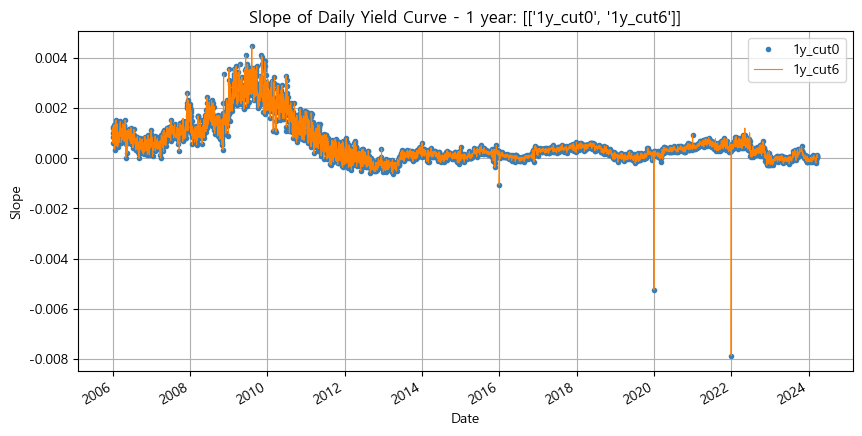

count    4520.000000
mean       -0.000003
std         0.000027
min        -0.000400
25%         0.000000
50%         0.000000
75%         0.000000
max         0.000412
Name: diff_1y, dtype: float64

In [26]:
def plot_slope(yield_gap, cols):
    global colors
    fig, ax = plt.subplots(figsize=(10, 5))
    yield_gap["slope"][cols].plot(
        title=f"Slope of Daily Yield Curve - 1 year: [{cols}]", 
        ax=ax, 
        grid=True,
        ylabel="Slope", 
        xlabel="Date", 
        legend=True, 
        style=['.', '-', '--'], 
        linewidth=0.8,  
        kind="line", 
        color=colors[:3]
    )
    plt.show()


cols = ["1y_cut0", "1y_cut6"]
yield_gaps_final["slope"]["diff_1y"] = yield_gaps_final["slope"][cols[0]] - yield_gaps_final["slope"][cols[1]]
plot_slope(yield_gaps_final, cols)
yield_gaps_final["slope"]["diff_1y"].describe()

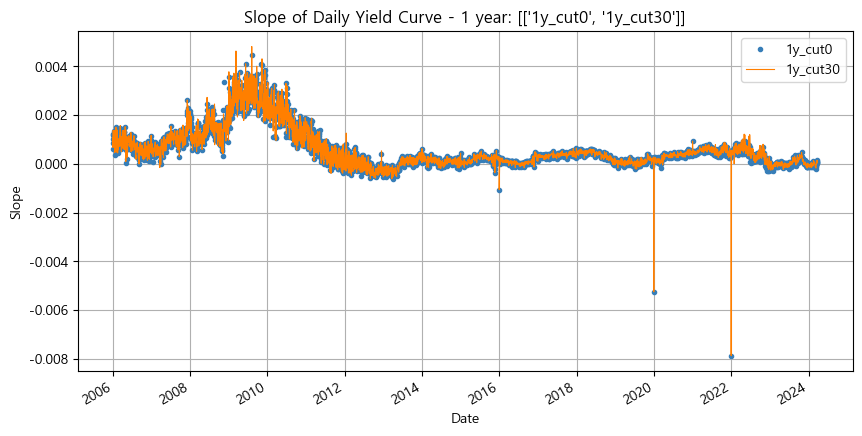

count    4520.000000
mean       -0.000007
std         0.000076
min        -0.001023
25%        -0.000012
50%         0.000000
75%         0.000015
max         0.001341
Name: diff_1y, dtype: float64

In [27]:
cols = ["1y_cut0", "1y_cut30"]
yield_gaps_final["slope"]["diff_1y"] = yield_gaps_final["slope"][cols[0]] - yield_gaps_final["slope"][cols[1]]
plot_slope(yield_gaps_final, cols)
yield_gaps_final["slope"]["diff_1y"].describe()

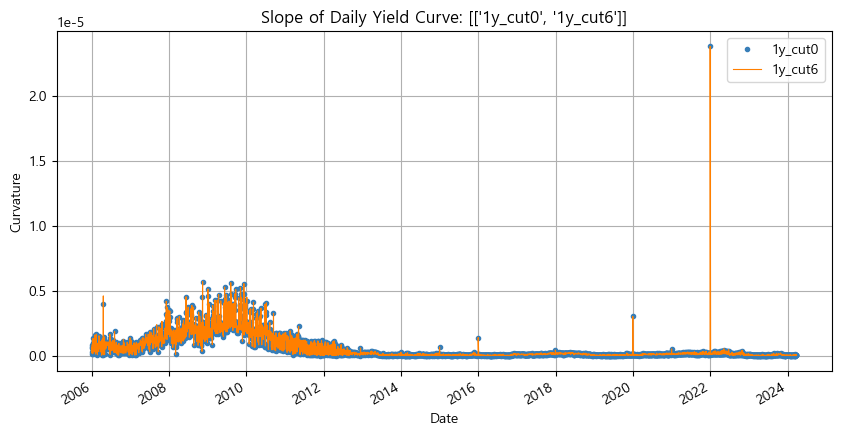

count    4.520000e+03
mean    -1.585587e-09
std      2.219082e-08
min     -7.499518e-07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.398045e-07
Name: diff_1y, dtype: float64

In [28]:

def plot_curvature(yield_gap, cols):
    global colors

    fig, ax = plt.subplots(figsize=(10, 5))
    yield_gap["curvature"][cols].plot(
        title=f"Slope of Daily Yield Curve: [{cols}]", 
        ax=ax, 
        grid=True,
        ylabel="Curvature", 
        xlabel="Date", 
        legend=True, 
        style=['.', '-', '--'], 
        linewidth=0.8,  
        kind="line", 
        color=colors[:3]
    )
    plt.show()


cols = ["1y_cut0", "1y_cut6"]
yield_gaps_final["curvature"]["diff_1y"] = yield_gaps_final["curvature"][cols[0]] - yield_gaps_final["curvature"][cols[1]]
plot_curvature(yield_gaps_final, cols)
yield_gaps_final["curvature"]["diff_1y"].describe()

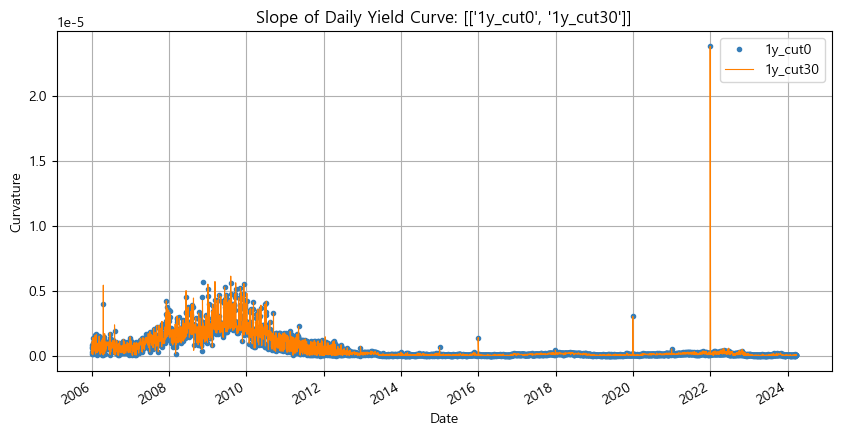

count    4.520000e+03
mean    -8.584052e-09
std      9.052460e-08
min     -1.824037e-06
25%     -9.071876e-09
50%      0.000000e+00
75%      4.582083e-09
max      2.338378e-06
Name: diff_1y, dtype: float64

In [29]:
cols = ["1y_cut0", "1y_cut30"]
yield_gaps_final["curvature"]["diff_1y"] = yield_gaps_final["curvature"][cols[0]] - yield_gaps_final["curvature"][cols[1]]
plot_curvature(yield_gaps_final, cols)
yield_gaps_final["curvature"]["diff_1y"].describe()

# Result

In [30]:
cutoff

[0, 6, 12, 18, 24, 30]

In [ ]:
result_slope_diff = pd.DataFrame().from_dict({
    f"1y_cut{v}_slope": yield_gaps_final["slope"]["1y_cut0"] - yield_gaps_final["slope"][f"1y_cut{v}"] 
    for v in cutoff[1:]   
})
result_slope_diff.index = yield_gaps_final["slope"].index

result_curvature_diff = pd.DataFrame().from_dict({
    f"1y_cut{v}_curvature": yield_gaps_final["curvature"]["1y_cut0"] - yield_gaps_final["curvature"][f"1y_cut{v}"] 
    for v in cutoff[1:]   
})
result_curvature_diff.index = yield_gaps_final["curvature"].index

In [ ]:
result_slope_diff.describe()

,1y_cut6_slope,1y_cut12_slope,1y_cut18_slope,1y_cut24_slope,1y_cut30_slope
count,4520.00000,4520.00000,4520.00000,4520.00000,4520.00000
mean,-0.00000,-0.00000,-0.00000,-0.00001,-0.00001
std,0.00003,0.00004,0.00006,0.00007,0.00008
min,-0.00040,-0.00048,-0.00102,-0.00102,-0.00102
25%,0.00000,0.00000,-0.00000,-0.00001,-0.00001
50%,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,0.00001,0.00002
max,0.00041,0.00041,0.00134,0.00134,0.00134


In [ ]:
result_curvature_diff.describe()

,1y_cut6_curvature,1y_cut12_curvature,1y_cut18_curvature,1y_cut24_curvature,1y_cut30_curvature
count,4520.00000,4520.00000,4520.00000,4520.00000,4520.00000
mean,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
std,0.00000,0.00000,0.00000,0.00000,0.00000
min,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
25%,0.00000,0.00000,-0.00000,-0.00000,-0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,0.00000,0.00000
max,0.00000,0.00000,0.00000,0.00000,0.00000
